# Практика №2

На прошлой практике мы реализовали DTW алгоритм. Он очень хорош и вроде как даже где-то применяется. Но у него есть существенные недостатки:

1) Для распознавания какого-либо слова необходимо иметь заранее подготовленные эталонные записи. Из этого вытекает проблема масштабирования системы с большим словарем.<br>
2) Подобная система имеет плохую устойчивость к шумам.<br>
3) По какому принципу вибирать нужные эталоны?<br>
4) Сколько должно быть таких эталонов, чтобы покрыть всю вариативность произнесеней?<br>
5) Чем больше эталонов, тем алгоритм вычислительнозатратен.<br>

В этом уроке мы перейдем от DTW к распознаванию по эталонному словарю. 

Эталон в графе теперь будет задаваться как последовательность фонем из словаря. Словарь для YES_NO (data/lexicon_yes_no.txt) выглядит следующим образом:

<b>YES</b>  SIL Y EH1 S SIL<br>
<b>NO</b>  SIL N OW1 SIL<br>

Словарь для цифр (data/lexicon_digits.txt):

<b>ZERO</b>  SIL Z IH1 R OW0 SIL<br>
<b>ZERO</b>  SIL Z IY1 R OW0 SIL<br>
<b>ONE</b>  SIL W AH1 N SIL<br>
<b>ONE</b>  SIL HH W AH1 N SIL<br>
<b>TWO</b>  SIL T UW1 SIL<br>
<b>THREE</b>  SIL TH R IY1 SIL<br>
<b>FOUR</b>  SIL F AO1 R SIL<br>
<b>FIVE</b>  SIL F AY1 V SIL<br>
<b>SIX</b>  SIL S IH1 K S SIL<br>
<b>SEVEN</b>  SIL S EH1 V AH0 N SIL<br>
<b>EIGHT</b>  SIL EY1 T SIL<br>
<b>NINE</b>  SIL N AY1 N SIL<br>

SIL здесь – это фонема паузы.
Как вы возможно заметили, для некторых слов имеется несколько вариантов фонемной транскрипции. Это позволяет лучше учесть фонетическое разнообразие в произнесении некоторых слов.

Каждой фонеме будет сопоставлен наиболее типичный для нее вектор признаков. В данном случае мы будем использовать среднее значение вектора признаков фонем, взятых из обучающего набора. Будем назвать это акустической моделью.

### Данные для обучения

Наша задача собрать статистику акустических признаков по каждой фонеме, находящейся в графе распознавания. В качестве обучающей выборки мы будем использовать подмножество данных librispeech (аудиозаписи чтения книг на английском). Для этого предварительно мной была получена покадровая разметка этого подмножества на фонемы. Схематично данный процесс представлен на картинке ниже:

![](https://drive.google.com/uc?export=view&id=16PdwggV_Cl6aaD4cu1MZ-fKzWzAvcFVw)

Файл разметки (ali_phones.txt) представлен в формате:

<b>filename1 phone_frame1 phone_frame2 phone_frame3 ...<br>
   filename2 phone_frame1 phone_frame2 phone_frame3 ...</b> 
   
Пример такой покадровой фонемной разметки одного файла с текстом "<b>MUCH COULD BE DONE IN THREE YEARS</b>" представлен ниже:

<b>1183-124566-0003 SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL M M M M M M M M M AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 CH CH CH CH CH CH CH CH CH CH CH K K K K
K K K K K UH1 UH1 UH1 UH1 D D D D D B B B B B B IY0 IY0 IY0 IY0 IY0 D D D D D D D D D D D D AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 N N
N N N N N N N N N N N N N SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SI
L SIL SIL SIL SIL SIL SIL SIL SIL IH1 IH1 IH1 IH1 IH1 IH1 IH1 IH1 IH1 IH1 IH1 N N N N N N N N N N SIL SIL SIL SIL SIL TH TH TH TH TH TH TH TH TH TH TH TH TH R R R R R R IY1 IY1
 IY1 IY1 IY1 IY1 IY1 Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y IH1 IH1 IH1 IH1 IH1 IH1 IH1 IH1 R R R R R R R R R R R R R R R Z Z Z Z Z Z Z Z Z Z Z Z Z Z Z Z Z Z Z Z SIL SIL SIL SIL</b>
 
Аудио файлы этих данных лежат в папке "data/train_librispeech_10h/wav_dir"

### Bootstrap

In [ ]:
!gdown --id '1meikF0XqBUnVZKoY3160MQ0R25lq-EMu'
!gdown --id '1f0LkW6I3Q5CnOThuNFAJ9umgnb2eU4Ox'

Downloading...
From: https://drive.google.com/uc?id=1meikF0XqBUnVZKoY3160MQ0R25lq-EMu
To: /content/lab2.zip
100% 1.66M/1.66M [00:00<00:00, 26.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1f0LkW6I3Q5CnOThuNFAJ9umgnb2eU4Ox
To: /content/train_librispeech_10h.zip
679MB [00:11, 57.7MB/s]


In [ ]:
!unzip -q lab2.zip
!unzip -q train_librispeech_10h.zip
!mv train_librispeech_10h lab2/data
!rm -rf lab2.zip sample_data train_librispeech_10h.zip
%cd lab2

/content/lab2


In [ ]:
import os
import numpy as np
import pandas as pd
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display

!jupyter nbextension enable --py widgetsnbextension --sys-prefix

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [ ]:
# рассмотрим пример такой записи:
wav_example = 'data/train_librispeech_10h/wav_dir/1183-124566-0003.flac'

# чтение wav файла:
x, sr = librosa.load(wav_example, sr=None)     # sr=None to preserve the native sampling rate

print('Number of samples: {}'.format(len(x)))
print('Sampling rate: {} Hz'.format(sr))
print('Duration: {:.2f} s'.format(len(x)/sr))  # ~ librosa.get_duration(x, sr)

# воспроизведение:
ipd.Audio(x, rate=sr)

Number of samples: 45680
Sampling rate: 16000 Hz
Duration: 2.85 s


Text(0.5, 1.0, 'Log-frequency power spectrogram')

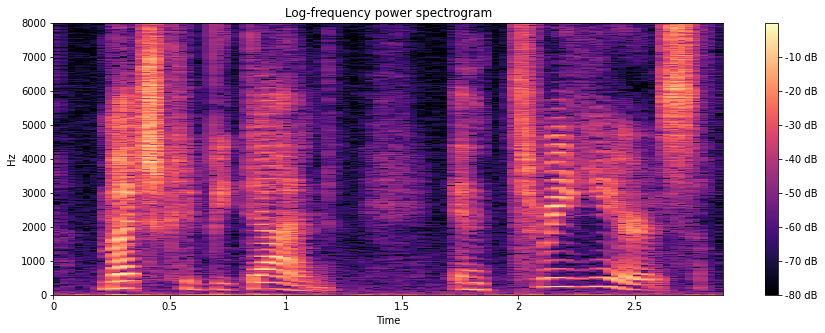

In [ ]:
# спектрограмма:
D = librosa.amplitude_to_db(np.abs(librosa.stft(x)), ref=np.max)
plt.figure(figsize=(15,5))
librosa.display.specshow(D, sr=sr, y_axis='hz', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')

### Подготовка данных

In [ ]:
# загрузка покадровой фонемной разметки в словарь:
def load_phone_aligment(aligment_file):
    ali_dict = {}
    with open(aligment_file, encoding='utf-8') as fn:
        for line in fn:
            line = line.strip().split()
            ali_dict[line[0]] = line[1:]
    return ali_dict

ali_file = 'data/train_librispeech_10h/ali_phones.txt'
ali_dict = load_phone_aligment(ali_file)

In [ ]:
# подсчет акустиеских признаков для записей из папки:
def load_data_dict(dir_path, count=None):
    data_dict = {}
    for step, wav_name in tqdm(enumerate(os.listdir(dir_path))):
        x, sr = librosa.load(os.path.join(dir_path, wav_name), sr=None) 
        mfcc = librosa.feature.mfcc(x, sr=sr, n_mfcc=13, 
                                    n_fft=int(sr * 0.025),
                                    hop_length=int(sr * 0.01))
        if count and step == count:
            print(f'Early stop at {step}th file..')
            break
        data_dict[wav_name.split('.')[0]] = mfcc.T  
    return data_dict

train_records_dir = 'data/train_librispeech_10h/wav_dir'
train_data_dict = load_data_dict(train_records_dir, count=100)

Early stop at 100th file..


In [ ]:
# инициализация списка допустимых фонем из предустановленного файла
def init_phones_dict(phones_file):
    phones_dict = {}
    with open(phones_file, encoding='utf-8') as fn:
        for line in fn:
            phones_dict[line.strip()] = []
    return phones_dict

phones_file = 'data/train_librispeech_10h/phones'
phones_dict = init_phones_dict(phones_file)

In [ ]:
# присвоим каждой фонеме набор ее признаков в соответствии с фонемной разметкой обучающей выборки
# количество кадров признаков может немного отличаться от количества размеченных фонем
# это связано с особенностми построения разметки в Kaldi
for file_name in train_data_dict.keys():
    file_feats = train_data_dict[file_name]
    file_ali = ali_dict[file_name]
    for frame in range(min(len(file_feats), len(file_ali))):
        phones_dict[file_ali[frame]].append(file_feats[frame])
        
# выведем статистику по кадой фонеме (некоторые фонемы вообще не используются, это особенности разметки в Kaldi):
count = 0
for phone in phones_dict.keys():
    if len(phones_dict[phone]) == 0:
        count +=1
    print(f'{phone:<3}: {len(phones_dict[phone])}')
print(f'Number of empty phones is: {count}')

SIL: 22368
SPN: 176
AA : 0
AA0: 76
AA1: 1923
AA2: 52
AE : 0
AE0: 28
AE1: 3778
AE2: 107
AH : 0
AH0: 5822
AH1: 2135
AH2: 81
AO : 0
AO0: 36
AO1: 2000
AO2: 59
AW : 0
AW0: 0
AW1: 1165
AW2: 13
AY : 0
AY0: 37
AY1: 2993
AY2: 214
B  : 1674
CH : 1108
D  : 4201
DH : 2126
EH : 0
EH0: 60
EH1: 3078
EH2: 116
ER : 0
ER0: 2833
ER1: 809
ER2: 8
EY : 0
EY0: 39
EY1: 2502
EY2: 170
F  : 2546
G  : 803
HH : 2229
IH : 0
IH0: 2827
IH1: 2540
IH2: 96
IY : 0
IY0: 2190
IY1: 2219
IY2: 84
JH : 892
K  : 3203
L  : 4098
M  : 3514
N  : 6400
NG : 1514
OW : 0
OW0: 134
OW1: 1845
OW2: 72
OY : 0
OY0: 12
OY1: 271
OY2: 22
P  : 2324
R  : 4218
S  : 7384
SH : 1450
T  : 6965
TH : 911
UH : 0
UH0: 3
UH1: 352
UH2: 0
UW : 0
UW0: 36
UW1: 1527
UW2: 58
V  : 1669
W  : 2417
Y  : 830
Z  : 3250
ZH : 102
Number of empty phones is: 17


# Задание 1: (решение)
Отрисовать кластеры признаков фонем "Y EH1 S N OW1" в двухмерном пространстве.

In [ ]:
phones_used = "Y EH1 S N OW1".split()
phones_dict_used = {
    k: v for k, v in phones_dict.items() if k in phones_used
}
display('phones feature counts:')
{k: len(v) for k, v in phones_dict_used.items()}

'phones feature counts:'

{'EH1': 3078, 'N': 6400, 'OW1': 1845, 'S': 7384, 'Y': 830}

In [ ]:
phones_features = pd.Series(phones_dict_used) \
    .to_frame(name='mfcc') \
    .explode('mfcc')

phones_features.index.name = 'phones'
phones_features = phones_features.reset_index()

mfcc_columns = [f'mfcc{i}' for i in range(13)]
phones_features[mfcc_columns] = phones_features['mfcc'].apply(pd.Series)
phones_features.drop(columns=['mfcc'], inplace=True)
phones_features

,phones,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12
0,EH1,-313.102325,120.471985,-38.352959,-12.029092,-41.714783,17.568356,-34.858894,-23.113949,0.085047,10.272794,1.106755,-24.331112,1.051318
1,EH1,-290.033722,89.411331,-50.504761,0.804938,-36.142822,5.292171,-32.958538,-17.043602,12.724199,0.359864,-10.147989,-20.676727,3.785226
2,EH1,-258.217773,78.820312,-60.202812,10.825054,-47.880703,-26.239082,-33.042400,-8.204278,4.814541,-22.293550,-11.968626,-17.267704,7.371429
3,EH1,-273.842255,51.004379,-41.047714,27.067047,-46.803604,-25.117359,-21.269442,-1.140712,1.941052,-15.260836,-3.928792,-6.904320,-0.823874
4,EH1,-418.620148,76.240448,-14.765412,48.856895,5.498321,4.317321,-6.725099,4.128353,3.223633,-6.651873,-6.079159,13.295414,9.269762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19532,Y,-482.573517,118.588112,47.243645,55.552650,24.250324,-12.171080,-2.716736,24.916780,-27.946102,-26.624283,4.192086,-3.521575,-8.210958
19533,Y,-410.675903,25.836355,61.447464,40.625427,-6.759648,-28.250093,20.438990,-37.407467,-26.502499,-22.053625,-14.992616,-25.719742,-23.498066
19534,Y,-398.700409,28.540054,74.164902,41.791672,-3.983187,-32.029518,19.730146,-48.234592,-27.583588,-18.954981,-16.272882,-24.502529,-24.966427
19535,Y,-392.133850,21.043339,72.406509,43.693977,-7.948767,-46.032898,18.991219,-47.269936,-35.556404,-14.712329,-20.069553,-32.417328,-25.217773


In [ ]:
X = phones_features[mfcc_columns]

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2,
                init='pca',
                perplexity=100.,
                early_exaggeration=24.,
                learning_rate=600.,
                angle=0.3,
                n_jobs=-1,
            )
xd = tsne.fit_transform(X)

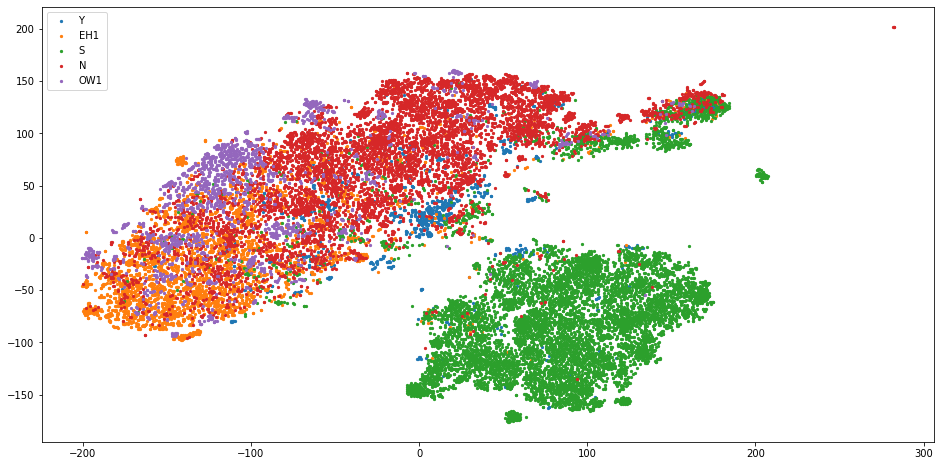

In [ ]:
viz_df = pd.DataFrame(xd, columns=['x', 'y'])
viz_df['phones'] = phones_features['phones']
viz_df.index = viz_df['phones']

plt.figure(figsize=(16,8))
for idx in phones_used:
    plt.scatter(viz_df.loc[idx,['x']],
                viz_df.loc[idx,['y']],
                label=idx,
                cmap='jet',
                s=5
               )

plt.legend()
plt.show()

# Задание 2: (решение)
Построить GMM модель для каждой фонемы 

In [ ]:
# соберем статистику на основе среднего значения для каждой фонемы
mean_phones_value = {}
for phone in phones_dict.keys():
    if phones_dict[phone]:
        mean_phones_value[phone] = np.mean(phones_dict[phone], axis=0)

In [ ]:
from sklearn.mixture import GaussianMixture

gmm_phones_value = {}
for phone in tqdm(phones_dict.keys()):
    if phones_dict[phone]:
        gmm_phones_value[phone] = GaussianMixture(n_components=3,
                                                  reg_covar=1e-2,
                                                  random_state=1000,
                                                 ) \
                                    .fit(np.array(phones_dict[phone]))

display('phones GMM model converged:')
{phone: model.converged_ for phone, model  in gmm_phones_value.items()}

'phones GMM model converged:'

{'AA0': True,
 'AA1': True,
 'AA2': True,
 'AE0': True,
 'AE1': True,
 'AE2': True,
 'AH0': True,
 'AH1': True,
 'AH2': True,
 'AO0': True,
 'AO1': True,
 'AO2': True,
 'AW1': True,
 'AW2': True,
 'AY0': True,
 'AY1': True,
 'AY2': True,
 'B': True,
 'CH': True,
 'D': True,
 'DH': True,
 'EH0': True,
 'EH1': True,
 'EH2': True,
 'ER0': True,
 'ER1': True,
 'ER2': True,
 'EY0': True,
 'EY1': True,
 'EY2': True,
 'F': True,
 'G': True,
 'HH': True,
 'IH0': True,
 'IH1': True,
 'IH2': True,
 'IY0': True,
 'IY1': True,
 'IY2': True,
 'JH': True,
 'K': True,
 'L': True,
 'M': True,
 'N': True,
 'NG': True,
 'OW0': True,
 'OW1': True,
 'OW2': True,
 'OY0': True,
 'OY1': True,
 'OY2': True,
 'P': True,
 'R': True,
 'S': True,
 'SH': True,
 'SIL': True,
 'SPN': True,
 'T': True,
 'TH': True,
 'UH0': True,
 'UH1': True,
 'UW0': True,
 'UW1': True,
 'UW2': True,
 'V': True,
 'W': True,
 'Y': True,
 'Z': True,
 'ZH': True}

### Инициализация фонемного графа

In [ ]:
# теперь будем распознавать по словарю, состоящему из конечных слов
# для этого нужно загрузить файл лексикона, который определяет из каких фонем состоят наши слова
def load_lexicon_dict(lexicon_file):
    lexicon_dict = {}
    with open(lexicon_file, encoding='utf-8') as fn:
        for line in fn:
            line = line.strip().split()
            lexicon_dict[line[0]] = line[1:]
    return lexicon_dict

lexicon_file = 'data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)

Узлы графа теперь представляют собой отдельные фонемы с переходом только в себя и следующий узел (переходов через несколько узлов уже не будет, так как пропуск фонемы в слове нежелателен). Схема такого графа для да/нет (для цифр по аналогии) представлена ниже:

![](https://drive.google.com/uc?export=view&id=1IJhR0l0YCPDge05ohigs0_P5gDX66fdM)

В качестве <b>model</b> мы будем хранить простой класс <b>AcousticModel</b>, который хранит в себе имя фонемы и ее среднее значение. Также у этого класса есть метод вычисления евклидовой дистанции от хранящегося в нем среднего значения признака фонемы до текущего признака распознаваемой записи, который передается этому методу. 

In [ ]:
class AcousticModel:
    def __init__(self, phone_name, phone_feats):
        self.phone_name = phone_name
        self.phone_feats = phone_feats
    def distance(self, input_feats):
        return float(np.sqrt(sum(pow(self.phone_feats - input_feats, 2))))

#-----------------------------TODO №2--------------------------------------------
# заменить акустическую модель на основе среднего значения признака на GMM модель
class GmmAcousticModel:
    def __init__(self, phone_name, phone_feats):
        self.phone_name = phone_name
        self.phone_feats = phone_feats
    def distance(self, input_feats):
        return -self.phone_feats.score(input_feats.reshape(1, -1))
#--------------------------------------------------------------------------------

class State:
    def __init__(self, model, index):  
        self.model = model                     # вектор признаков узла
        self.is_final = False                  # является ли этот узел финальнвм в слове
        self.word = None                       # слово эталона (назначается только для финального узла)
        self.best_token = None                 # лучший токен (по минимуму дистанции) в узле
        self.current_word = None               # текущее слово эталона
        self.next_states = []                  # список следующих узлов
        self.index = index                     # индекс узла 

        
def load_graph(lexicon_dict, phones_feats, model_ctor):
    start_state = State(model_ctor(None, None), 0)
    graph = [start_state, ]
    state_index = 1
    for word in lexicon_dict.keys():
        previous_state = start_state
        for phone in lexicon_dict[word]:
            state = State(model_ctor(phone, phones_feats[phone]), state_index)
            state.current_word = word           # слово эталона теперь будет храниться в каждом узле
            state.next_states.append(state)     # add loop
            previous_state.next_states.append(state)
            previous_state = state 
            graph.append(state)
            state_index += 1
        if state:
            state.word = word
            state.is_final = True
    return graph


def print_graph(graph, model_name):
    if not os.path.exists('exp'):
        os.mkdir('exp')
    with open(f'exp/{model_name}_graph.txt', 'w') as fn:
        np.set_printoptions(formatter={'float': '{: 0.1f}'.format})
        for state in graph:
            next_state_indexes = [s.index for s in state.next_states]
            fn.write("State: index={} word={} is_final={} next_state_indexes={} phone={} \n".format(
                state.index, state.word, state.is_final, next_state_indexes, state.model.phone_name))
    print(f"*** SEE exp/{model_name}_graph.txt ***")

In [ ]:
acoustic_model_ctor = lambda phone, feats: AcousticModel(phone, feats)
graph = load_graph(lexicon_dict, mean_phones_value, acoustic_model_ctor)
print_graph(graph, 'AcousticModel')

*** SEE exp/AcousticModel_graph.txt ***


In [ ]:
gmm_model_ctor = lambda phone, feats: GmmAcousticModel(phone, feats)
graph = load_graph(lexicon_dict, gmm_phones_value, gmm_model_ctor)
print_graph(graph, 'GmmAcousticModel')

*** SEE exp/GmmAcousticModel_graph.txt ***


In [ ]:
class Token:
    def __init__(self, state, dist=0.0, word=""):
        self.state = state       # стейт графа, в котором токен находится в текущий момент
        self.dist = dist         # общая накопленная дистанция пути, пройденного токеном
        self.word = word         # слово, которое распозналось токеном
        self.alive = True


def beam_pruning(next_tokens, threshold):   
    best_token = next_tokens[np.argmin([token.dist for token in next_tokens])]
    for token in next_tokens:
        if token.dist > best_token.dist + threshold:
            token.alive = False
    return next_tokens


def state_pruning(next_tokens):
    for token in next_tokens:  
        if not token.state.best_token:
            token.state.best_token = token
        else:
            if token.dist <= token.state.best_token.dist:
                token.state.best_token.alive = False
                token.state.best_token = token
            else:
                token.alive = False              
    # сбрасываем best_token на None для всеx узлов графа:
    for token in next_tokens:                                                   
        if token.state.best_token:                     
            token.state.best_token = None              
    return next_tokens


def recognize(filename, features, graph, recognition_results, beam_threshold):

    start_state = graph[0]
    active_tokens = [Token(start_state), ]
    next_tokens = []

    #for ftr_frame in tqdm(features, desc="recognition..."):
    for ftr_frame in features:
        for token in active_tokens:
            if token.alive:
                for transition_state in token.state.next_states:
                    new_token = Token(transition_state, token.dist, token.word)
                    new_token.dist += transition_state.model.distance(ftr_frame)
                    next_tokens.append(new_token)
        # state and beam prunings:
        next_tokens = state_pruning(next_tokens)         
        next_tokens = beam_pruning(next_tokens, beam_threshold) 

        active_tokens = next_tokens
        next_tokens = []                                    
        
    # поиск финальных токенов:
    final_tokens = []
    for token in active_tokens:
        if token.state.is_final and token.alive:
            final_tokens.append(token)

    # если нет финальных, то берем лучший из выживших:
    if len(final_tokens) != 0:
        win_token = final_tokens[np.argmin([token.dist for token in final_tokens])]
    else:
        alive_tokens = [token for token in active_tokens if token.alive]
        win_token = alive_tokens[np.argmin([token.dist for token in alive_tokens])]
        win_token.state.word = win_token.state.current_word

    # вывод результата DTW
    print(f"result: {filename:<27} ==> {win_token.state.word}")

    # совпадает ли запись с полученным эталоном:  
    record_word = filename.split('_')[0]
    etalon_word = win_token.state.word.split('_')[0]
    recognition_results.append(etalon_word.lower() == record_word)

    return recognition_results

In [ ]:
def run_recognizer(records_data_dict, graph, beam_threshold=10):
    start_time = time.time()
    recognition_results = []

    for filename in tqdm(records_data_dict.keys()):    
        recognition_results = recognize(filename, records_data_dict[filename], graph, recognition_results, beam_threshold)

    print("-" * 60)
    print(f"WER is: {(1 - sum(recognition_results)/len(recognition_results))*100:.2f}%")
    print(f"Total time is: {time.time() - start_time:.2f} sec")
    print("-" * 60)

In [ ]:
def load_data_dict(dir_path):
    data_dict = {}
    for wav_name in os.listdir(dir_path):
        x, sr = librosa.load(os.path.join(dir_path, wav_name), sr=None) 
        mfcc = librosa.feature.mfcc(x, sr=sr, n_mfcc=13, 
                                    n_fft=int(sr * 0.025),
                                    hop_length=int(sr * 0.01))
        data_dict[wav_name] = mfcc.T
    
    return data_dict

### Запустим наше распознавание на базе YES_NO

In [ ]:
lexicon_file = 'data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, mean_phones_value, acoustic_model_ctor)
records_data_dict = load_data_dict("data/yes_no/records")

display('Acoustic model: beam_threshold=5')
run_recognizer(records_data_dict, graph, beam_threshold=5)

display('Acoustic model: beam_threshold=100')
run_recognizer(records_data_dict, graph, beam_threshold=100)

'Acoustic model: beam_threshold=5'

result: no_4abb2400_nohash_0.wav    ==> NO
result: no_41474817_nohash_0.wav    ==> NO
result: no_49af4432_nohash_0.wav    ==> NO
result: no_4394fc7c_nohash_0.wav    ==> NO
result: yes_ff63ab0b_nohash_0.wav   ==> YES
result: yes_fc94edb0_nohash_0.wav   ==> YES
result: yes_39a6b995_nohash_0.wav   ==> NO
result: no_ad89eb1e_nohash_0.wav    ==> NO
result: yes_39a12648_nohash_0.wav   ==> YES
result: yes_fe1916ba_nohash_0.wav   ==> NO

------------------------------------------------------------
WER is: 20.00%
Total time is: 0.15 sec
------------------------------------------------------------


'Acoustic model: beam_threshold=100'

result: no_4abb2400_nohash_0.wav    ==> NO
result: no_41474817_nohash_0.wav    ==> NO
result: no_49af4432_nohash_0.wav    ==> NO
result: no_4394fc7c_nohash_0.wav    ==> NO
result: yes_ff63ab0b_nohash_0.wav   ==> YES
result: yes_fc94edb0_nohash_0.wav   ==> YES
result: yes_39a6b995_nohash_0.wav   ==> NO
result: no_ad89eb1e_nohash_0.wav    ==> NO
result: yes_39a12648_nohash_0.wav   ==> YES
result: yes_fe1916ba_nohash_0.wav   ==> NO

------------------------------------------------------------
WER is: 20.00%
Total time is: 0.16 sec
------------------------------------------------------------


In [ ]:
lexicon_file = 'data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, gmm_phones_value, gmm_model_ctor)
records_data_dict = load_data_dict("data/yes_no/records")

display('Gmm model: beam_threshold=5')
run_recognizer(records_data_dict, graph, beam_threshold=5)

display('Gmm model: beam_threshold=100')
run_recognizer(records_data_dict, graph, beam_threshold=100)

'Gmm model: beam_threshold=5'

result: no_4abb2400_nohash_0.wav    ==> NO
result: no_41474817_nohash_0.wav    ==> YES
result: no_49af4432_nohash_0.wav    ==> YES
result: no_4394fc7c_nohash_0.wav    ==> NO
result: yes_ff63ab0b_nohash_0.wav   ==> YES
result: yes_fc94edb0_nohash_0.wav   ==> YES
result: yes_39a6b995_nohash_0.wav   ==> NO
result: no_ad89eb1e_nohash_0.wav    ==> NO
result: yes_39a12648_nohash_0.wav   ==> YES
result: yes_fe1916ba_nohash_0.wav   ==> NO

------------------------------------------------------------
WER is: 40.00%
Total time is: 0.83 sec
------------------------------------------------------------


'Gmm model: beam_threshold=100'

result: no_4abb2400_nohash_0.wav    ==> YES
result: no_41474817_nohash_0.wav    ==> NO
result: no_49af4432_nohash_0.wav    ==> NO
result: no_4394fc7c_nohash_0.wav    ==> NO
result: yes_ff63ab0b_nohash_0.wav   ==> YES
result: yes_fc94edb0_nohash_0.wav   ==> YES
result: yes_39a6b995_nohash_0.wav   ==> YES
result: no_ad89eb1e_nohash_0.wav    ==> NO
result: yes_39a12648_nohash_0.wav   ==> YES
result: yes_fe1916ba_nohash_0.wav   ==> YES

------------------------------------------------------------
WER is: 10.00%
Total time is: 2.60 sec
------------------------------------------------------------


### Запустим наше распознавание на базе Digits

In [ ]:
lexicon_file = 'data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, mean_phones_value, acoustic_model_ctor)
records_data_dict = load_data_dict("data/digits/records")

display('Acoustic model: beam_threshold=5')
run_recognizer(records_data_dict, graph, beam_threshold=5)

display('Acoustic model: beam_threshold=100')
run_recognizer(records_data_dict, graph, beam_threshold=100)

'Acoustic model: beam_threshold=5'

result: four_ffbb695d_nohash_0.wav  ==> TWO
result: five_ffd2ba2f_nohash_0.wav  ==> THREE
result: one_fc2411fe_nohash_0.wav   ==> NINE
result: three_feb1d305_nohash_0.wav ==> THREE
result: nine_ccea893d_nohash_0.wav  ==> NINE
result: zero_f852895b_nohash_0.wav  ==> THREE
result: eight_daf230ac_nohash_0.wav ==> TWO
result: five_f852895b_nohash_0.wav  ==> THREE
result: seven_fd32732a_nohash_0.wav ==> THREE
result: six_ffd2ba2f_nohash_0.wav   ==> SEVEN
result: eight_da584bc0_nohash_4.wav ==> ONE
result: zero_f92e49f3_nohash_3.wav  ==> NINE
result: seven_fe5c4a7a_nohash_0.wav ==> THREE
result: three_fce96bac_nohash_0.wav ==> THREE
result: nine_fbe51750_nohash_0.wav  ==> TWO
result: two_fb2f3242_nohash_0.wav   ==> FOUR
result: six_ffbb695d_nohash_0.wav   ==> THREE
result: one_ffa76c4a_nohash_0.wav   ==> NINE
result: two_fce65496_nohash_0.wav   ==> ONE
result: four_fce65496_nohash_0.wav  ==> NINE

------------------------------------------------------------
WER is: 85.00%
Total time is: 0.34

'Acoustic model: beam_threshold=100'

result: four_ffbb695d_nohash_0.wav  ==> FOUR
result: five_ffd2ba2f_nohash_0.wav  ==> FIVE
result: one_fc2411fe_nohash_0.wav   ==> ONE
result: three_feb1d305_nohash_0.wav ==> THREE
result: nine_ccea893d_nohash_0.wav  ==> NINE
result: zero_f852895b_nohash_0.wav  ==> THREE
result: eight_daf230ac_nohash_0.wav ==> THREE
result: five_f852895b_nohash_0.wav  ==> THREE
result: seven_fd32732a_nohash_0.wav ==> SIX
result: six_ffd2ba2f_nohash_0.wav   ==> SIX
result: eight_da584bc0_nohash_4.wav ==> SEVEN
result: zero_f92e49f3_nohash_3.wav  ==> ZERO
result: seven_fe5c4a7a_nohash_0.wav ==> THREE
result: three_fce96bac_nohash_0.wav ==> SEVEN
result: nine_fbe51750_nohash_0.wav  ==> ONE
result: two_fb2f3242_nohash_0.wav   ==> THREE
result: six_ffbb695d_nohash_0.wav   ==> THREE
result: one_ffa76c4a_nohash_0.wav   ==> ONE
result: two_fce65496_nohash_0.wav   ==> NINE
result: four_fce65496_nohash_0.wav  ==> FOUR

------------------------------------------------------------
WER is: 55.00%
Total time is: 0.53

In [ ]:
lexicon_file = 'data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, gmm_phones_value, gmm_model_ctor)
records_data_dict = load_data_dict("data/digits/records")

display('Gmm model: beam_threshold=5')
run_recognizer(records_data_dict, graph, beam_threshold=5)

display('Gmm model: beam_threshold=100')
run_recognizer(records_data_dict, graph, beam_threshold=100)

'Gmm model: beam_threshold=5'

result: four_ffbb695d_nohash_0.wav  ==> TWO
result: five_ffd2ba2f_nohash_0.wav  ==> FOUR
result: one_fc2411fe_nohash_0.wav   ==> NINE
result: three_feb1d305_nohash_0.wav ==> SEVEN
result: nine_ccea893d_nohash_0.wav  ==> TWO
result: zero_f852895b_nohash_0.wav  ==> FIVE
result: eight_daf230ac_nohash_0.wav ==> THREE
result: five_f852895b_nohash_0.wav  ==> FIVE
result: seven_fd32732a_nohash_0.wav ==> THREE
result: six_ffd2ba2f_nohash_0.wav   ==> SEVEN
result: eight_da584bc0_nohash_4.wav ==> SEVEN
result: zero_f92e49f3_nohash_3.wav  ==> ONE
result: seven_fe5c4a7a_nohash_0.wav ==> TWO
result: three_fce96bac_nohash_0.wav ==> THREE
result: nine_fbe51750_nohash_0.wav  ==> NINE
result: two_fb2f3242_nohash_0.wav   ==> TWO
result: six_ffbb695d_nohash_0.wav   ==> TWO
result: one_ffa76c4a_nohash_0.wav   ==> TWO
result: two_fce65496_nohash_0.wav   ==> TWO
result: four_fce65496_nohash_0.wav  ==> THREE

------------------------------------------------------------
WER is: 75.00%
Total time is: 3.19 sec


'Gmm model: beam_threshold=100'

result: four_ffbb695d_nohash_0.wav  ==> FOUR
result: five_ffd2ba2f_nohash_0.wav  ==> FIVE
result: one_fc2411fe_nohash_0.wav   ==> ONE
result: three_feb1d305_nohash_0.wav ==> SIX
result: nine_ccea893d_nohash_0.wav  ==> NINE
result: zero_f852895b_nohash_0.wav  ==> FIVE
result: eight_daf230ac_nohash_0.wav ==> SIX
result: five_f852895b_nohash_0.wav  ==> FIVE
result: seven_fd32732a_nohash_0.wav ==> SEVEN
result: six_ffd2ba2f_nohash_0.wav   ==> SIX
result: eight_da584bc0_nohash_4.wav ==> SIX
result: zero_f92e49f3_nohash_3.wav  ==> ZERO
result: seven_fe5c4a7a_nohash_0.wav ==> SEVEN
result: three_fce96bac_nohash_0.wav ==> SEVEN
result: nine_fbe51750_nohash_0.wav  ==> NINE
result: two_fb2f3242_nohash_0.wav   ==> TWO
result: six_ffbb695d_nohash_0.wav   ==> SIX
result: one_ffa76c4a_nohash_0.wav   ==> FOUR
result: two_fce65496_nohash_0.wav   ==> NINE
result: four_fce65496_nohash_0.wav  ==> FOUR

------------------------------------------------------------
WER is: 35.00%
Total time is: 23.82 sec
--

### <b>Задание №1</b> (5 баллов):
Отрисовать кластеры признаков фонем "Y EH1 S N OW1" в двухмерном пространстве. Для понижения размерности можно воспользоваться алгоритмом t-SNE -- https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html. Все пять кластеров должны помещаться на один рисунок и иметь разные цвета. Также укажите на графике какой цвет какой фонеме соответствует.  

### <b>Задание №2</b> (5 баллов):
Заменить модель среднего значения фонемы на GMM. Количестов смесей для каждой фонемы можно выставить в 3. Теперь вместо расстояния мы будем измерять вероятность принадлежности кадра признаков к GMM модели фонемы, находящейся в конкретном узле графа. Чтобы использовать это значение в парадигме нашего алгоритма, в роле дистанции нам нужно брать значение -log(x), где x -- предсказанная вероятность. Тогда чем выше вероятность, тем такая импровизированная дистанция будет меньше. Ссылка на питоновскую реализацию GMM -- https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html.

Что стало с качеством распознавания на двух тестах?

- Качество распознавания с использованием GMM выше по сравнению с моделью, основанной на подсчете расстояния до среднего значения признаков фонем
- GMM хуже работает для моделей с низким порогом отсечения beam threshold
- GMM на двух гауссианах показала лучший результат, чем на трех, и лучший, чем модель подстчета расстояний до среднего (пример ниже)

In [ ]:
gmm_phones_value2 = {}
for phone in tqdm(phones_dict.keys()):
    if phones_dict[phone]:
        gmm_phones_value2[phone] = GaussianMixture(n_components=2,
                                                  reg_covar=1e-3,
                                                  random_state=1000,
                                                 ) \
                                    .fit(np.array(phones_dict[phone]))

display('phones GMM model converged:')
{phone: model.converged_ for phone, model  in gmm_phones_value2.items()}

'phones GMM model converged:'

{'AA0': True,
 'AA1': True,
 'AA2': True,
 'AE0': True,
 'AE1': True,
 'AE2': True,
 'AH0': True,
 'AH1': True,
 'AH2': True,
 'AO0': True,
 'AO1': True,
 'AO2': True,
 'AW1': True,
 'AW2': True,
 'AY0': True,
 'AY1': True,
 'AY2': True,
 'B': True,
 'CH': True,
 'D': True,
 'DH': True,
 'EH0': True,
 'EH1': True,
 'EH2': True,
 'ER0': True,
 'ER1': True,
 'ER2': True,
 'EY0': True,
 'EY1': True,
 'EY2': True,
 'F': True,
 'G': True,
 'HH': True,
 'IH0': True,
 'IH1': True,
 'IH2': True,
 'IY0': True,
 'IY1': True,
 'IY2': True,
 'JH': True,
 'K': True,
 'L': True,
 'M': True,
 'N': True,
 'NG': True,
 'OW0': True,
 'OW1': True,
 'OW2': True,
 'OY0': True,
 'OY1': True,
 'OY2': True,
 'P': True,
 'R': True,
 'S': True,
 'SH': True,
 'SIL': True,
 'SPN': True,
 'T': True,
 'TH': True,
 'UH0': True,
 'UH1': True,
 'UW0': True,
 'UW1': True,
 'UW2': True,
 'V': True,
 'W': True,
 'Y': True,
 'Z': True,
 'ZH': True}

### Распознавание на базе YES_NO на смеси двух гауссианов

In [ ]:
lexicon_file = 'data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, gmm_phones_value2, gmm_model_ctor)
records_data_dict = load_data_dict("data/yes_no/records")

display('Gmm model: beam_threshold=5')
run_recognizer(records_data_dict, graph, beam_threshold=5)

display('Gmm model: beam_threshold=100')
run_recognizer(records_data_dict, graph, beam_threshold=100)

'Gmm model: beam_threshold=5'

result: no_4abb2400_nohash_0.wav    ==> NO
result: no_41474817_nohash_0.wav    ==> NO
result: no_49af4432_nohash_0.wav    ==> NO
result: no_4394fc7c_nohash_0.wav    ==> NO
result: yes_ff63ab0b_nohash_0.wav   ==> YES
result: yes_fc94edb0_nohash_0.wav   ==> YES
result: yes_39a6b995_nohash_0.wav   ==> NO
result: no_ad89eb1e_nohash_0.wav    ==> NO
result: yes_39a12648_nohash_0.wav   ==> YES
result: yes_fe1916ba_nohash_0.wav   ==> NO

------------------------------------------------------------
WER is: 20.00%
Total time is: 0.74 sec
------------------------------------------------------------


'Gmm model: beam_threshold=100'

result: no_4abb2400_nohash_0.wav    ==> YES
result: no_41474817_nohash_0.wav    ==> NO
result: no_49af4432_nohash_0.wav    ==> NO
result: no_4394fc7c_nohash_0.wav    ==> NO
result: yes_ff63ab0b_nohash_0.wav   ==> YES
result: yes_fc94edb0_nohash_0.wav   ==> YES
result: yes_39a6b995_nohash_0.wav   ==> YES
result: no_ad89eb1e_nohash_0.wav    ==> NO
result: yes_39a12648_nohash_0.wav   ==> YES
result: yes_fe1916ba_nohash_0.wav   ==> YES

------------------------------------------------------------
WER is: 10.00%
Total time is: 2.27 sec
------------------------------------------------------------


### Распознавание на базе Digits на смеси двух гауссианов

In [ ]:
lexicon_file = 'data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, gmm_phones_value2, gmm_model_ctor)
records_data_dict = load_data_dict("data/digits/records")

display('Gmm model: beam_threshold=5')
run_recognizer(records_data_dict, graph, beam_threshold=5)

display('Gmm model: beam_threshold=100')
run_recognizer(records_data_dict, graph, beam_threshold=100)

'Gmm model: beam_threshold=5'

result: four_ffbb695d_nohash_0.wav  ==> TWO
result: five_ffd2ba2f_nohash_0.wav  ==> FOUR
result: one_fc2411fe_nohash_0.wav   ==> NINE
result: three_feb1d305_nohash_0.wav ==> THREE
result: nine_ccea893d_nohash_0.wav  ==> ZERO
result: zero_f852895b_nohash_0.wav  ==> FIVE
result: eight_daf230ac_nohash_0.wav ==> THREE
result: five_f852895b_nohash_0.wav  ==> FIVE
result: seven_fd32732a_nohash_0.wav ==> THREE
result: six_ffd2ba2f_nohash_0.wav   ==> SEVEN
result: eight_da584bc0_nohash_4.wav ==> SEVEN
result: zero_f92e49f3_nohash_3.wav  ==> TWO
result: seven_fe5c4a7a_nohash_0.wav ==> SEVEN
result: three_fce96bac_nohash_0.wav ==> SIX
result: nine_fbe51750_nohash_0.wav  ==> SIX
result: two_fb2f3242_nohash_0.wav   ==> TWO
result: six_ffbb695d_nohash_0.wav   ==> TWO
result: one_ffa76c4a_nohash_0.wav   ==> TWO
result: two_fce65496_nohash_0.wav   ==> TWO
result: four_fce65496_nohash_0.wav  ==> TWO

------------------------------------------------------------
WER is: 75.00%
Total time is: 2.95 sec
--

'Gmm model: beam_threshold=100'

result: four_ffbb695d_nohash_0.wav  ==> FOUR
result: five_ffd2ba2f_nohash_0.wav  ==> FIVE
result: one_fc2411fe_nohash_0.wav   ==> ONE
result: three_feb1d305_nohash_0.wav ==> SIX
result: nine_ccea893d_nohash_0.wav  ==> NINE
result: zero_f852895b_nohash_0.wav  ==> FIVE
result: eight_daf230ac_nohash_0.wav ==> SIX
result: five_f852895b_nohash_0.wav  ==> FIVE
result: seven_fd32732a_nohash_0.wav ==> SIX
result: six_ffd2ba2f_nohash_0.wav   ==> SIX
result: eight_da584bc0_nohash_4.wav ==> SIX
result: zero_f92e49f3_nohash_3.wav  ==> ZERO
result: seven_fe5c4a7a_nohash_0.wav ==> SEVEN
result: three_fce96bac_nohash_0.wav ==> THREE
result: nine_fbe51750_nohash_0.wav  ==> NINE
result: two_fb2f3242_nohash_0.wav   ==> TWO
result: six_ffbb695d_nohash_0.wav   ==> SIX
result: one_ffa76c4a_nohash_0.wav   ==> ONE
result: two_fce65496_nohash_0.wav   ==> EIGHT
result: four_fce65496_nohash_0.wav  ==> FOUR

------------------------------------------------------------
WER is: 30.00%
Total time is: 21.32 sec
----

Группа MADE-ML-22 Дмитрий Чepникoв